In [2]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [13]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
# from src.ParticleFilter import PFHeston
# from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from typing import Dict, Optional, List, Any
from numdifftools import Hessian

In [6]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


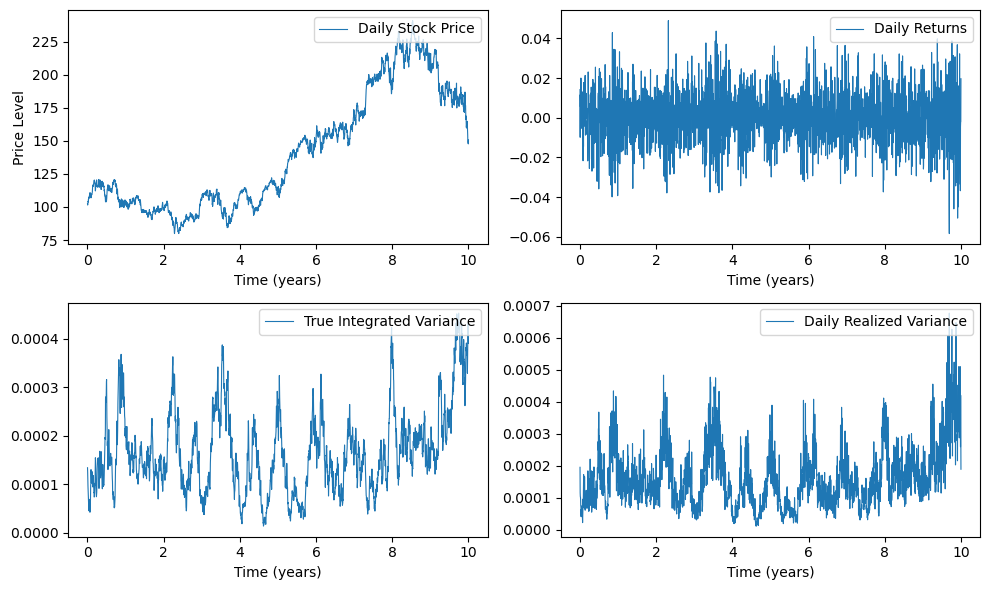

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [8]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### RV

In [39]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.010514
theta: 0.000141
xi: 0.001308
sigma: 0.002862
Negative Log-Likelihood: -10976.292394
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.01051397 0.00014128 0.00130778 0.00286178]


### HAR-RV

In [57]:
def har_rv_forecast(train_RV, test_RV):
    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    lag1_tr = train_RV.shift(1)
    lag5_tr = train_RV.rolling(5).mean().shift(1)
    lag21_tr = train_RV.rolling(21).mean().shift(1)
    
    df_tr = pd.DataFrame({
        'y': train_RV,
        'x1': lag1_tr,
        'x5': lag5_tr,
        'x21': lag21_tr
    }).dropna()
    
    X_tr = sm.add_constant(df_tr[['x1', 'x5', 'x21']])
    model = sm.OLS(df_tr['y'], X_tr)
    results = model.fit()
    
    beta_const = results.params['const']
    beta_x1 = results.params['x1']
    beta_x5 = results.params['x5']
    beta_x21 = results.params['x21']
    
    full_RV = pd.concat([train_RV, test_RV])
    
    # Compute lags on the full series
    lag1_full = full_RV.shift(1)
    lag5_full = full_RV.rolling(5).mean().shift(1)
    lag21_full = full_RV.rolling(21).mean().shift(1)
    
    # Extract ONLY the test period features
    test_start_idx = len(train_RV)
    test_end_idx = len(full_RV)
    
    # Test set features
    x1_test = lag1_full.iloc[test_start_idx:test_end_idx]
    x5_test = lag5_full.iloc[test_start_idx:test_end_idx]
    x21_test = lag21_full.iloc[test_start_idx:test_end_idx]
    
    forecasts = beta_const + beta_x1 * x1_test + beta_x5 * x5_test + beta_x21 * x21_test
    
    # forecasts = forecasts.dropna()
    
    if len(forecasts) == 0:
        raise ValueError("All forecasts are NaN. Ensure training data has >21 periods and no missing values.")
    
    # Align with test_RV index
    forecast_index = test_RV.index[:len(forecasts)]
    forecasts = pd.Series(forecasts.values, index=forecast_index, name='HAR_RV_pred')
    
    # Get fitted values (in-sample fit) from training phase
    fitted_values = results.fittedvalues
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'HAR_RV_fitted'
    
    # Return parameters as a dictionary for clarity
    params_dict = {
        'const': beta_const,
        'x1': beta_x1,
        'x5': beta_x5, 
        'x21': beta_x21
    }
    
    return np.array(forecasts), np.array(fitted_values), params_dict, results

In [59]:
pred_HAR, fit_HAR, params_HAR, results_HAR = har_rv_forecast(train_RV, test_RV)

## Plot

In [69]:
params_HAR['x1'] + params_HAR['x5'] + params_HAR['x21']

0.9350444947217865

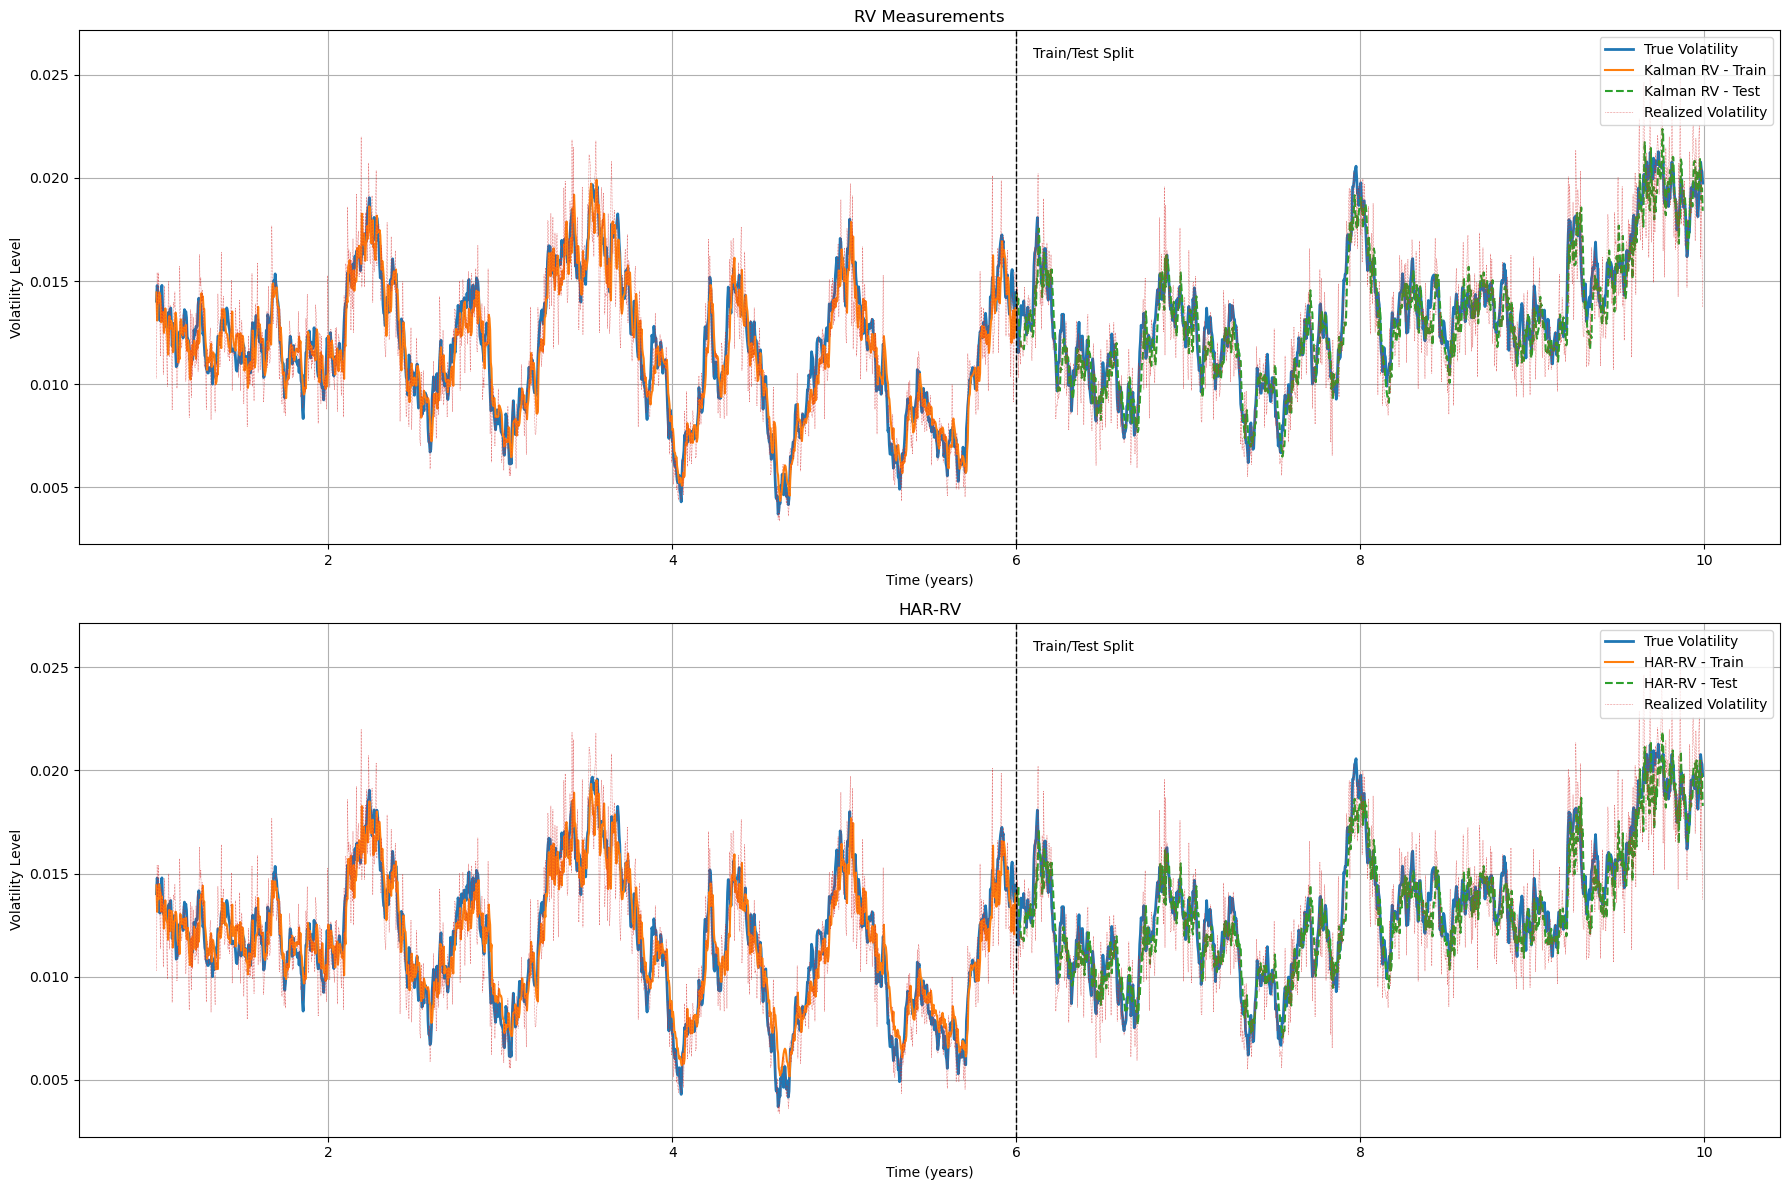

In [62]:
v_item = 'V_pred'

titles_all = ["RV Measurements", "HAR-RV"]
labels_all = ["Kalman RV", "HAR-RV"]
train_all = [train_result_rv[v_item], fit_HAR]
test_all = [test_result_rv[v_item], pred_HAR]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)

In [72]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'HAR-RV']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001072, QLIKE: 0.014905
HAR-RV             RMSE: 0.001085, QLIKE: 0.014820


In [18]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,5.027054,6.287298,1.291022
theta,0.028964,0.036905,0.027551
xi,0.059970,0.507085,0.280506
mu,0.116571,0.095864,0.041478
sigma,0.248988,NaN,NaN
rho,-0.401621,-0.499996,-0.228878


In [19]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 4))))

omega      0.0093
beta       0.7827
gamma      0.2087
xi        -0.5017
phi        0.9350
tau_1      0.0742
tau_2      0.0048
sigma_u    0.2413
dtype: float64

In [20]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 1230.00model/s]


In [21]:
mcs_mse_results_90

,pvalues,status
models,,
4,0.0000,excluded
3,0.0001,excluded
2,0.0030,excluded
1,1.0000,included


In [22]:
mcs_qlike_results_90

,pvalues,status
models,,
3,0.0,excluded
2,0.0,excluded
4,0.0,excluded
1,1.0,included


In [23]:
mcs_mse_results_75

,pvalues,status
models,,
4,0.0000,excluded
3,0.0000,excluded
2,0.0029,excluded
1,1.0000,included


In [24]:
mcs_qlike_results_75

,pvalues,status
models,,
3,0.0,excluded
2,0.0,excluded
4,0.0,excluded
1,1.0,included
